In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import get_class_from_package, HELMConverter
from node import MolSentenceNode #TODO: change after Filter implementation <- ?
from generator import MCTS

c:\Users\fsfsf\anaconda3\envs\molgen-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = get_class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
if lang_class_name.endswith("HELM"): #TODO: should be removed after .lang inclusion
    lang.converter = HELMConverter().load(repo_root + "data/helm/library/chembl_35_monomer_library.xml")
model_class = get_class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = get_class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = get_class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = get_class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

In [8]:
for f in filters:
    print(vars(f))

{}


Search is started.
0- time: 0.02, count_rollouts: 1, reward: 0.14489307120579065, node: PEPTIDE1{[ac].[dL].L.[dH].G.I.W}$$$$
1- time: 0.07, count_rollouts: 2, reward: -0.145736868778519, node: PEPTIDE1{R.R.R.W.W.W.R}$$$$
2- time: 0.12, count_rollouts: 3, reward: -0.194923431880075, node: PEPTIDE1{[ac].S.G.K.F}$$$$
3- time: 0.15, count_rollouts: 4, reward: 0.154206922756893, node: PEPTIDE1{R.[dW].F.[Abu].I.L}$$$$
4- time: 0.18, count_rollouts: 5, reward: -0.2743575278754539, node: PEPTIDE1{Y.G.G.F.S.[am]}$$$$
5- time: 0.23, count_rollouts: 6, reward: -0.557797389196737, node: PEPTIDE1{G.S.H.A.G.A.A.G.I.L.T.V.L.[am]}$$$$
6- time: 0.32, count_rollouts: 7, reward: -0.3545242837282845, node: PEPTIDE1{F.[dF].G.F.N.K.F.V.F.V.F.G.Y.F.E.R.K.R.L.R.K.K.[am]}$$$$
7- time: 0.47, count_rollouts: 8, reward: -0.4028530063274097, node: PEPTIDE1{A.L.E.D.K.P.E.G.[am]}$$$$
8- time: 0.52, count_rollouts: 9, reward: -0.746003443770563, node: PEPTIDE1{T.P.R.E.A.R.R.K.K.R.G.[am]}$$$$
9- time: 0.59, count_roll

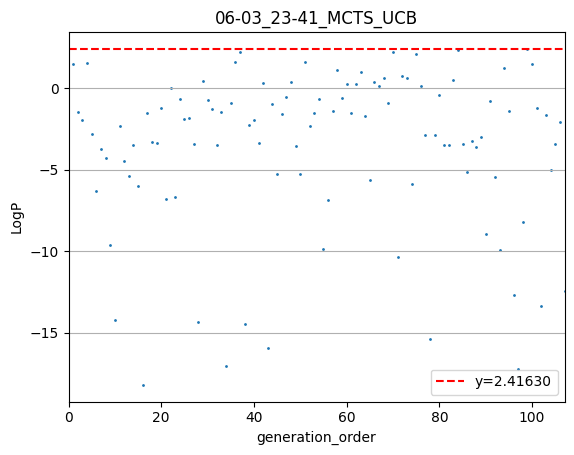

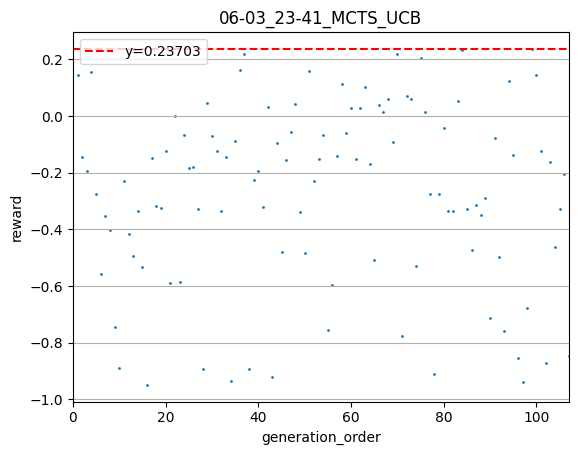

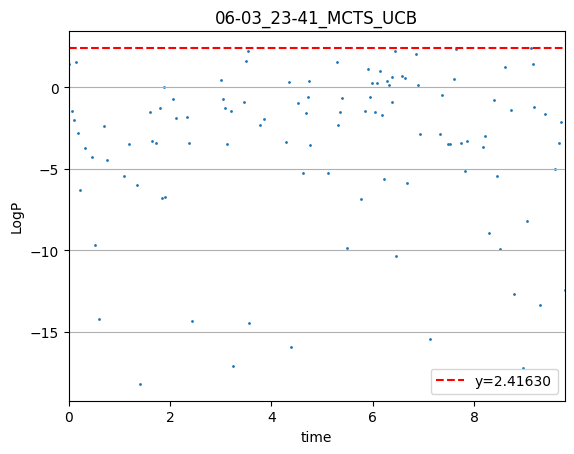

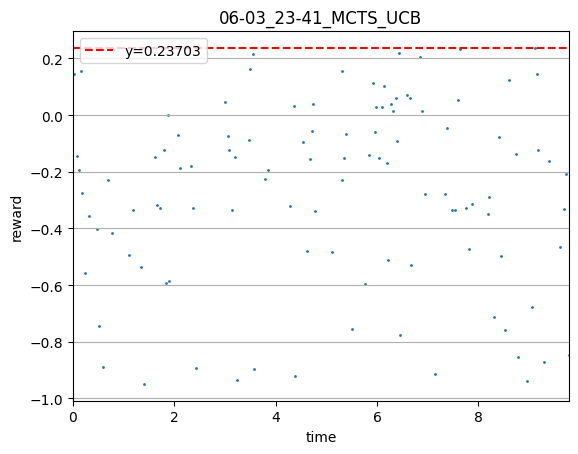

Search is completed.


In [9]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang)

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)